# Article Relevance Prediction for NeotomaDB

This notebook contains the following tasks:
1. Extract CrossRef metadata of articles that currently exist in Neotoma.csv (positive cases)
2. Extract CrossRef metadata of new articles sent from Simon
3. Extract CrossRef metadata of other negative cases that do not exist in NeotomaDB (negative cases)
4. Data cleaning and saved as csv file
5. Create train test dataset
6. Baseline model: logistic regression with BOW features


### Imports

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
pd.set_option("display.max_colwidth", 200)

## 1. Extract CrossRef Metadata for Articles in NeotomaDB

The neotoma.csv file is provided by our partner. 

It contains 6889 site records from 2316 sites.

The csv file contains data contributed from 758 distinct articles. 

Note that only 244 of these articles has abstract.

In [33]:
import requests
import json
import os

In [34]:
# load csv
# neotoma = pd.read_csv("../data/hackathon_data/neotoma_crossref_fixed.csv").iloc[:, 0:-2]
# neotoma.info()

In [35]:
# neotoma['doi'].value_counts()

In [36]:
# neotoma['sitename'].value_counts()

### 8 DOI Not Found, Replaced

In [37]:
# dot_status_df = pd.DataFrame(doi_status)
# dot_status_df.query("status_code == 404")['doi'].to_list()

In [38]:
# doi_replace = {
#     '10.2307/1551601\xa0 ' : '10.2307/1551601',
#     '10.2307/1551050\xa0 ' : '10.2307/1551050',
#     '10.1016/j.revpalbo.2004.09.004\xa0 ': '10.1016/j.revpalbo.2004.09.004',
#     '10.1016/j.quascirev.2016.09.023.' : '10.1016/j.quascirev.2016.09.023',
#     'Widga, C., S.N. Lengyel, J. Saunders, G. Hodgins, J.D. Walker, and A.D. Wanamaker. 2017. Late Pleistocene proboscidean population dynamics in the North American Midcontinent. Boreas 46(4):772-782. [DOI: 10.1111/bor.12235]': '10.1111/bor.12235',
#     "Fiedel, S.J. 2018. The spore conundrum: Does a dung fungus decline signal humans' arrival in the Eastern United States?. Quaternary International 466:247e255. [DOI: doi.org/10.1016/j.quaint.2015.11.130]": '10.1016/j.quaint.2015.11.130',
#     'Joyce, D.J. 2006. Chronology and new research on the Schaefer mammoth (? Mammuthus primigenius) site, Kenosha County, Wisconsin, USA,. Quaternary International 142:44-57. [DOI: doi:10.1016/j.quaint.2005.03.004]': '10.1016/j.quaint.2005.03.004',
#     'Overstreet, D.F., and M.F. Kolb. 2003. Geoarchaeological contexts for Late Pleistocene archaeological sites with human‐modified woolly mammoth remains in southeastern Wisconsin, USA. Geoarchaeology 18(1):91-114. [DOI: DOI:10.1002/gea.10052]': '10.1002/gea.10052'
# }
# neotoma['doi'].replace(to_replace=doi_replace, inplace=True)

### Download metadata from CrossRef

In [39]:
# # Query Metadata from DOI
# doi_list = neotoma['doi'].unique().tolist()
# # testing purpose: take the first 10
# # input_doi = doi_list
# input_doi = doi_list

# doi_status = {}
# doi_status['doi'] = input_doi
# doi_status['status_code'] = []

# for doi in input_doi:
#     cross_ref_url = f"https://api.crossref.org/works/{doi}"

#     # make a request to the API
#     cross_ref_response = requests.get(cross_ref_url)

#     doi_status['status_code'].append(cross_ref_response.status_code)

#     if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = cross_ref_response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/crossref'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

#     else:
#         print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

### Positive Cases CrossRef Data Import

In [40]:
# Set the directory path
directory_path = "../data/raw/crossref/positive/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

757

In [41]:
# initialize empty dataframe
neotoma_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/positive/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    neotoma_crossref_df = pd.concat([neotoma_crossref_df, onefile])

neotoma_crossref_df["target"] = 1

neotoma_crossref_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 0
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   757 non-null    object
 1   DOI                     757 non-null    object
 2   ISSN                    745 non-null    object
 3   URL                     757 non-null    object
 4   alternative-id          598 non-null    object
 5   author                  751 non-null    object
 6   container-title         757 non-null    object
 7   content-domain          757 non-null    object
 8   created                 757 non-null    object
 9   deposited               757 non-null    object
 10  indexed                 757 non-null    object
 11  is-referenced-by-count  757 non-null    object
 12  issn-type               745 non-null    object
 13  issue                   673 non-null    object
 14  issued                  757 non-null    object
 15  journal-

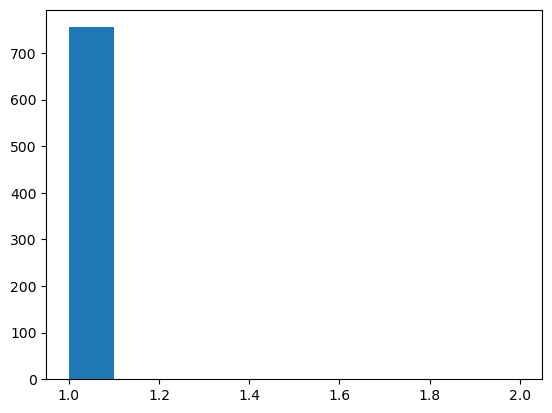

In [42]:
counts = neotoma_crossref_df['DOI'].value_counts()
plt.hist(counts)
plt.show()

### Negative Cases CrossRef Data Import

#### Sample code to search GDD

In [43]:
# #term to search GeoDeepDive
# term = "Animal"
# # Number of articles to return
# n = 100

# response = requests.get("https://geodeepdive.org/api/articles?term=" + term + "&max=" + str(n) + "&type=journal-article")
# if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/negative'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

# else:
#     print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

In [44]:
# Set the directory path
directory_path = "../data/raw/crossref/negative/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

1786

In [45]:
# initialize empty dataframe
negative_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/negative/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    negative_crossref_df = pd.concat([negative_crossref_df, onefile])
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [46]:
negative_crossref_df.head(3)

index                            DOI                    ISSN  \
0  message         10.1002/chin.201507318             [0931-7597]   
0  message         10.1002/chem.201590048             [0947-6539]   
0  message  10.1080/13698575.2015.1031645  [1369-8575, 1469-8331]   

                                               URL    archive  \
0         http://dx.doi.org/10.1002/chin.201507318  [Portico]   
0         http://dx.doi.org/10.1002/chem.201590048        NaN   
0  http://dx.doi.org/10.1080/13698575.2015.1031645        NaN   

                                                                                                                                                                                                    author  \
0                              [{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]   
0  [{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...   
0  [{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...   

                    container-title  \
0                      [ChemInform]   
0  [Chemistry - A European Journal]   
0      [Health, Risk &amp; Society]   

                                                       content-domain  \
0                      {'domain': [], 'crossmark-restriction': False}   
0                      {'domain': [], 'crossmark-restriction': False}   
0  {'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}   

                                                                                            created  \
0  {'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}   
0  {'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}   
0  {'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}   

                                                                                          deposited  \
0   {'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}   
0   {'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}   
0  {'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}   

   ... volume                   alternative-id  \
0  ...     46                              NaN   
0  ...     21                              NaN   
0  ...     17  [10.1080/13698575.2015.1031645]   

                                                                                                                                                                                                 assertion  \
0                                                                                                                                                                                                      NaN   
0                                                                                                                                                                                                      NaN   
0  [{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...   

                                                                                funder  \
0                                                                                  NaN   
0                                                                                  NaN   
0  [{'name': 'Australia Research Council Discovery Project', 'award': 

In [47]:
negative_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1786 non-null   object
 1   DOI                     1786 non-null   object
 2   ISSN                    1784 non-null   object
 3   URL                     1786 non-null   object
 4   archive                 475 non-null    object
 5   author                  1335 non-null   object
 6   container-title         1786 non-null   object
 7   content-domain          1786 non-null   object
 8   created                 1786 non-null   object
 9   deposited               1786 non-null   object
 10  indexed                 1786 non-null   object
 11  is-referenced-by-count  1786 non-null   object
 12  issn-type               1784 non-null   object
 13  issue                   1501 non-null   object
 14  issued                  1786 non-null   object
 15  journal

In [48]:
#Setting target column
negative_crossref_df["target"] = 0
negative_crossref_df.head(3)

index                            DOI                    ISSN  \
0  message         10.1002/chin.201507318             [0931-7597]   
0  message         10.1002/chem.201590048             [0947-6539]   
0  message  10.1080/13698575.2015.1031645  [1369-8575, 1469-8331]   

                                               URL    archive  \
0         http://dx.doi.org/10.1002/chin.201507318  [Portico]   
0         http://dx.doi.org/10.1002/chem.201590048        NaN   
0  http://dx.doi.org/10.1080/13698575.2015.1031645        NaN   

                                                                                                                                                                                                    author  \
0                              [{'given': 'Kristof', 'family': 'Kranjc', 'sequence': 'first', 'affiliation': []}, {'given': 'Marijan Koc', 'family': 'evar', 'sequence': 'additional', 'affiliation': []}]   
0  [{'given': 'Jin-Long', 'family': 'Wang', 'sequence': 'first', 'affiliation': []}, {'given': 'Jian-Wei', 'family': 'Liu', 'sequence': 'additional', 'affiliation': []}, {'given': 'Bing-Zhang', 'fami...   
0  [{'given': 'Davina', 'family': 'Lohm', 'sequence': 'first', 'affiliation': []}, {'given': 'Mark', 'family': 'Davis', 'sequence': 'additional', 'affiliation': []}, {'given': 'Paul', 'family': 'Flow...   

                    container-title  \
0                      [ChemInform]   
0  [Chemistry - A European Journal]   
0      [Health, Risk &amp; Society]   

                                                       content-domain  \
0                      {'domain': [], 'crossmark-restriction': False}   
0                      {'domain': [], 'crossmark-restriction': False}   
0  {'domain': ['www.tandfonline.com'], 'crossmark-restriction': True}   

                                                                                            created  \
0  {'date-parts': [[2015, 1, 29]], 'date-time': '2015-01-29T10:38:37Z', 'timestamp': 1422527917000}   
0  {'date-parts': [[2015, 3, 12]], 'date-time': '2015-03-12T19:27:18Z', 'timestamp': 1426188438000}   
0  {'date-parts': [[2015, 4, 15]], 'date-time': '2015-04-15T12:23:23Z', 'timestamp': 1429100603000}   

                                                                                          deposited  \
0   {'date-parts': [[2021, 7, 2]], 'date-time': '2021-07-02T09:01:39Z', 'timestamp': 1625216499000}   
0   {'date-parts': [[2021, 7, 3]], 'date-time': '2021-07-03T01:59:45Z', 'timestamp': 1625277585000}   
0  {'date-parts': [[2017, 6, 23]], 'date-time': '2017-06-23T05:27:18Z', 'timestamp': 1498195638000}   

   ...                   alternative-id  \
0  ...                              NaN   
0  ...                              NaN   
0  ...  [10.1080/13698575.2015.1031645]   

                                                                                                                                                                                                 assertion  \
0                                                                                                                                                                                                      NaN   
0                                                                                                                                                                                                      NaN   
0  [{'value': 'The publishing and review policy for this title is described in its Aims & Scope.', 'order': 1, 'name': 'peerreview_statement', 'label': 'Peer Review Statement'}, {'value': 'http://www...   

                                                                                funder  \
0                                                                                  NaN   
0                                                                                  NaN   
0  [{'name': 'Australia Research Council Discovery Project', 'award': ['DP11010181']}]   

       

### Combine the dataframes & Initial Variable Selection

In [49]:
combined_metadata_df = pd.concat([neotoma_crossref_df, negative_crossref_df])

crossref_keep_col = ['DOI',
 'URL',
 'abstract',
 'author',
 'container-title',
 'is-referenced-by-count', # times cited
 'language',
 'published', # datetime
 'publisher', 
 'subject', # keywords
 'subtitle', # subtitle are missing sometimes
 'title', # article title
 'target'
 ]

metadata_df = combined_metadata_df.loc[:, crossref_keep_col]


### Add Maybe cases to the dataset

Note:
-  all the doi in the newlyprovided csv are new articles
- We will lable "maybe" cases as positive since the cost of their false positive is low

In [50]:
maybe_list1 = pd.read_csv('../data/raw/article_list/pollen_doc_labels.csv')

maybe_list2 = pd.read_csv('../data/raw/article_list/project_2_labeled_data.csv')

combined_maybe = pd.concat([maybe_list1, maybe_list2])

# Get the list of duplicated doi
count = pd.DataFrame(combined_maybe['doi'].value_counts())
dup_doi = count.query('doi >1').index.to_list()

# check if doi exist in previous dois
maybe_list2['duplicated'] = maybe_list2['doi'].apply(lambda x: x in dup_doi)
maybe_list2_new = maybe_list2.query('duplicated == False')
maybe_list2_new.head()

maybe_list = pd.concat([maybe_list1, maybe_list2_new])
maybe_list.shape
# exist_doi = metadata_df['DOI'].to_list()
# dup_list = []
# for doi in maybe_list['doi'].to_list():
#     if doi in exist_doi:
#         dup_list.append(doi)

(1965, 24)

In [51]:
maybe_list['Label'].value_counts()

Not Neotoma      1798
Neotoma            94
Maybe Neotoma      73
Name: Label, dtype: int64

In [52]:
maybe_list['target'] = maybe_list['Label'].apply(lambda x: 1 if x in ['Neotoma', 'Maybe Neotoma'] else 0)
maybe_list['target'].value_counts()

0    1798
1     167
Name: target, dtype: int64

In [53]:
maybe_list = maybe_list.rename(columns={'doi': 'DOI'})

maybe_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1533
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  1965 non-null   int64  
 1   Text                1965 non-null   object 
 2   pmid                1965 non-null   int64  
 3   DOI                 1940 non-null   object 
 4   abstract            1882 non-null   object 
 5   month               1965 non-null   int64  
 6   year                1965 non-null   int64  
 7   day                 1965 non-null   int64  
 8   jabbrv              1965 non-null   object 
 9   journal             1965 non-null   object 
 10  keywords            1855 non-null   object 
 11  lastname            0 non-null      float64
 12  firstname           0 non-null      float64
 13  address             0 non-null      float64
 14  email               0 non-null      float64
 15  Label               1965 non-null   object 
 16  Pre-Lo

>  We will need: 
> - doi
> - keywords (subject)
> - Text (title)
> - abstract
> - year
> - journal
> - keywords

> Note: Decided to use CrossRef information, not directly from the csv file to replicate the deployment data environment. 


In [54]:
# # Download CrossRef

# # Query Metadata from DOI
# doi_list_new = maybe_list['DOI'].unique().tolist()
# # testing purpose: take the first 10
# # input_doi = doi_list
# input_doi = doi_list_new

# doi_status = {}
# doi_status['DOI'] = input_doi
# doi_status['status_code'] = []

# for doi in input_doi:
#     cross_ref_url = f"https://api.crossref.org/works/{doi}"

#     # make a request to the API
#     cross_ref_response = requests.get(cross_ref_url)

#     doi_status['status_code'].append(cross_ref_response.status_code)

#     if cross_ref_response.status_code == 200:

#         # save data
#         ref_data = cross_ref_response.json()
        
#         # create the directory if it doesn't exist 
#         directory = '../data/raw/crossref/mixed_0512'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         # save the JSON data to a file
#         doi_clean = doi.replace("/", "_")
#         filename = f'crossref_{doi_clean}.json'
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'w') as outfile:
#             json.dump(ref_data, outfile)

#     else:
#         print("DOI not found:", doi, "status_code", cross_ref_response.status_code)

##### Convert new cases into pandas DF

In [55]:
# Convert into Pandas DataFrame

# Set the directory path
directory_path = "../data/raw/crossref/mixed_0512/"
# Get a list of all files and directories in the directory
files_and_directories = os.listdir(directory_path)
# Filter out the directories to get only the files
files = [file for file in files_and_directories if os.path.isfile(os.path.join(directory_path, file))]
if '.DS_Store' in files:
    files.remove('.DS_Store')
len(files)

1919

In [56]:
# initialize empty dataframe
mixed_crossref_df = pd.DataFrame()

# Populate the cross ref df
for f in files:
    file_path = f"../data/raw/crossref/mixed_0512/{f}"
    onefile = pd.read_json(file_path)
    onefile = pd.DataFrame(onefile.loc[:, 'message']).T.reset_index()
    
    # merge
    mixed_crossref_df = pd.concat([mixed_crossref_df, onefile])

mixed_crossref_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1919 entries, 0 to 0
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1919 non-null   object
 1   DOI                     1919 non-null   object
 2   ISSN                    1914 non-null   object
 3   URL                     1919 non-null   object
 4   alternative-id          1537 non-null   object
 5   assertion               1032 non-null   object
 6   author                  1916 non-null   object
 7   container-title         1919 non-null   object
 8   content-domain          1919 non-null   object
 9   created                 1919 non-null   object
 10  deposited               1919 non-null   object
 11  funder                  1041 non-null   object
 12  indexed                 1919 non-null   object
 13  is-referenced-by-count  1919 non-null   object
 14  issn-type               1914 non-null   object
 15  issue  

In [57]:
# Join target to the Data Frame
mixed_crossref_df['DOI'] = mixed_crossref_df['DOI'].str.lower()
maybe_list['DOI'] = maybe_list['DOI'].str.lower()

mixed_crossref_df_target = pd.merge(mixed_crossref_df, maybe_list, on='DOI')
# mixed_crossref_df_target[['abstract_y', 'abstract_x']].tail()

In [58]:
# join with the rest of the data -> metadata_df
crossref_keep_col = ['DOI',
 'URL',
 'abstract_y',
 'author',
 'container-title',
 'is-referenced-by-count', # times cited
 'language',
 'published', # datetime
 'publisher', 
 'subject', # keywords
 'subtitle', # subtitle are missing sometimes
 'title', # article title
 'target'
 ]

mixdata_df = mixed_crossref_df_target.loc[:, crossref_keep_col].rename(columns={'abstract_y' : 'abstract'})
mixdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1919 entries, 0 to 1918
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     1919 non-null   object
 1   URL                     1919 non-null   object
 2   abstract                1837 non-null   object
 3   author                  1916 non-null   object
 4   container-title         1919 non-null   object
 5   is-referenced-by-count  1919 non-null   object
 6   language                1739 non-null   object
 7   published               1919 non-null   object
 8   publisher               1919 non-null   object
 9   subject                 1888 non-null   object
 10  subtitle                1919 non-null   object
 11  title                   1919 non-null   object
 12  target                  1919 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 209.9+ KB


In [59]:
metadata_df = pd.concat([metadata_df, mixdata_df])
metadata_df.shape

(4462, 13)

## 2. Data Wrangling - Tidy Data Columns

In [60]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4462 entries, 0 to 1918
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     4462 non-null   object
 1   URL                     4462 non-null   object
 2   abstract                2092 non-null   object
 3   author                  4002 non-null   object
 4   container-title         4462 non-null   object
 5   is-referenced-by-count  4462 non-null   object
 6   language                4191 non-null   object
 7   published               4461 non-null   object
 8   publisher               4458 non-null   object
 9   subject                 4368 non-null   object
 10  subtitle                4462 non-null   object
 11  title                   4462 non-null   object
 12  target                  4462 non-null   int64 
dtypes: int64(1), object(12)
memory usage: 488.0+ KB


In [61]:
# Reset index after concatenation
metadata_df = metadata_df.reset_index().drop('index', axis = 1)
metadata_df.head()
metadata_df.index

RangeIndex(start=0, stop=4462, step=1)

| Variable | Description | Preprocessing |
| --- | --- | --- |
| DOI | Digital Object Identifier | Temporarily keep it as primary ID. Will drop it during training. |
| URL | Link to the article | Temporarily keep it in case we need to look into the article. Will drop it during training.|
|abstract | Abstract of the article. Only 244 NeotomaDB articles has it. | Convert to Bag of Words representation|
|author | Author of the article | Consider droping due to duplicate names and various format and spelling |
|container-title | Title of the article's container | Keep as a categorical feature. Apply one-hot encoding|
| content-domain | The publisher's url. | Drop|
| short-container-title | Abbreviated title of the article's container. |Drop since it duplicates the information in container-title|
| is-referenced-by-count| Count of the article being referenced by other article | Keep as a numeric feature.|
| language | Language of the article | Keep as a feature. One hot encoding.|
| published | contain datatime information about when the article is published. | Extract the year and month. Keep as numeric features|
| publisher | Publisher name | Keep as Bag of words feature. |
|subject| What subject the article is about. | Keep as categorical feature. Bag of Words feature. |
| subtitle | Subtitle | Keep as Bag of words feature.|
| title | Title of the article. | Keep as Bag of words feature.|
| type | Tyle of the article (e.g. journal-article) | Drop (since we will focus on journal articles only).|



#### Decisions for Feature Engineering & Feature Selection

- Published year: drop it because both positive and negative cases will have common values for this variable.

- Language: when this information is missing from CrossRef, we use language detector to add it back. Current focus in English articles.

- We decided to join title, subtitle, abstract into one descriptive text feature. This solve the problem of missing values and incorporate all descriptive information in a feature.

- Authors: There are two options we are trying out: 1. Remove to make the model more generalizable. 2. Using NeotomaDB, get a list of high-frequent/mid-frequent/less-frequent author, and create 3 binary features indicating whether the article author contains anyone in the list.

- Journal: Similar to authors, we'd like to convert it to an Ordinal feature, where : 0 = published by a journal that do not currently contributed to Neotoma, 1 means the article is published by a less-frequent journal(only 1), 2 = mid-frequent (2-5), 3 = high frequent (>5)


### Tidy - Published Year & Month

Note on column "published": 
1. Article 353 from Neotoma has missing published time information, thus manually replaced based on online information.
2. Many articles do not have published month information, thus we will not use this as a feature.

In [473]:
# check missing values in published col
metadata_df[metadata_df['published'].notnull() == False]


DOI                                         URL  \
353  10.1007/0-387-21710-x_13  http://dx.doi.org/10.1007/0-387-21710-x_13   

    abstract  \
353      NaN   

                                                                                                                                                                      author  \
353  [{'given': 'Ulli M.', 'family': 'Huber', 'sequence': 'first', 'affiliation': []}, {'given': 'Vera', 'family': 'Markgraf', 'sequence': 'additional', 'affiliation': []}]   

                                                                                    container-title  \
353  [Fire and Climatic Change in Temperate Ecosystems of the Western Americas, Ecological Studies]   

    is-referenced-by-count language published        publisher subject  \
353                     14      NaN       NaN  Springer-Verlag     NaN   

    subtitle  \
353       []   

                                                                                  title  \
353  [Holocene Fire Frequency and Climate Change at Rio Rubens Bog, Southern Patagonia]   

     target  
353       1

In [474]:
# published is missing for record 0
# need to replace it before extracting date-parts
print(metadata_df.index[metadata_df['published'].notnull() == False])
metadata_df['published'][353] = {'date-parts':[[2003, 0]]}
# metadata_df.iloc[353, :]

Int64Index([353], dtype='int64')


/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/1595980108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['published'][353] = {'date-parts':[[2003, 0]]}


In [475]:
# Extract year and month
metadata_df['published_year'] = metadata_df['published'].apply(lambda x: int(x['date-parts'][0][0]))

#### Some EDA for published_year

In [476]:
data1 = pd.DataFrame(metadata_df[metadata_df['target'] == 1].loc[:,'published_year'].value_counts().sort_index())
data2 = metadata_df[metadata_df['target'] == 0].loc[:,'published_year'].value_counts().sort_index()
data1


published_year
1903               1
1951               1
1958               1
1960               1
1962               4
...              ...
2019              10
2020               2
2021               1
2022               2
2023              25

[66 rows x 1 columns]

In [477]:
import altair as alt
alt.Chart(metadata_df).mark_bar().encode(
    alt.X('published_year', bin=alt.Bin(maxbins=30)),
    alt.Y('count()')
).facet('target', columns=1)

alt.FacetChart(...)

### Tidy - Affiliation & Authors

Exploring the article counts per author, we noticed that each author has < 30 relevant articles. Each author could also contribute to articles that are not relevant to Neotoma. 
Thus, considering the sparse data problem that OHE could possibly introduce, we decided to find the top 15 most common authors in articles that are relevant to Neotoma, and add a feature "contains_author" = 1 when an article's author is any of the Neotoma common author; =0 otherwise.

In [478]:
# combined_metadata_df["affiliation"]= combined_metadata_df['author'].apply(lambda x: [d["affiliation"] for d in x])

In [628]:
metadata_df['full_name'].value_counts()

[]                                                                                                                                 477
[W Watts]                                                                                                                            6
[R Wilson]                                                                                                                           6
[D Tudball]                                                                                                                          5
[A Dixit, S Dixit, J Smol]                                                                                                           4
                                                                                                                                  ... 
[S Laursen, M Hassi, S Hough]                                                                                                        1
[I Stengel, G Götz, M Weil, P Bäuerle]                 

In [479]:
# combine author names
from collections import Counter

def concat_names(l):
    try:
        return [d['given'][0] + ' ' + d['family'] for d in l]
    except:
        return []

# combine names for both class
metadata_df["full_name"] = metadata_df['author'].apply(concat_names)


In [480]:
metadata_df.head(1)

DOI                                          URL  \
0  10.2478/s11756-007-0072-x  http://dx.doi.org/10.2478/s11756-007-0072-x   

  abstract  \
0      NaN   

                                                                                                                                                                                                    author  \
0  [{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...   

  container-title is-referenced-by-count language  \
0      [Biologia]                     13       en   

                      published                                publisher  \
0  {'date-parts': [[2006, 12]]}  Springer Science and Business Media LLC   

                                                                                                                                              subject  \
0  [Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]   

  subtitle  \
0       []   

                                                                                                                                  title  \
0  [The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest]   

   target  published_year                                            full_name  
0       1            2006  [M Pražáková, J Veselý, J Fott, V Majer, J Kopáček]

#### Get list of common authors
- Option1: use the authors in neotoma.csv only (comment out)
- Option2: query NeotomaDB, get top authors in the entire database (this notebook)

In [481]:
# Option 1 (Not used in this notebook 
# authors = []

# for i in metadata_df[metadata_df["full_name"].isna() == False]["full_name"]:
#     for author in i:
#         authors.append(author)
# # create counter of authors in positive class
# counter_object = Counter(authors)
# keys = counter_object.keys()
# num_values = len(keys)

# # most common authors
# counter_object.most_common(15)

# most_common = [author[0] for author in counter_object.most_common(15)]
# most_common

In [482]:
# Option 2: Get a list from Neotoma DB
all_author = pd.read_csv('../data/raw/article_list/author_names.csv', header=None, skiprows=2)
all_author['first_name'] = all_author[1].apply(lambda x: str(x)[0])
all_author['full_name'] = all_author['first_name'] + ' ' + all_author[0]

all_author.head()

0     1 first_name  full_name
0    Davis  M.B.          M    M Davis
1  Janssen  C.R.          C  C Janssen
2   Sirkin  L.A.          L   L Sirkin
3    Denny  C.S.          C    C Denny
4    Rubin    M.          M    M Rubin

##### Note on encoding the author variable
- since an article could have multiple authors, the features are encoded to 3 binary variables to account for the fact that when multiple authors in the same field contribute the chance of being relevant is higher.

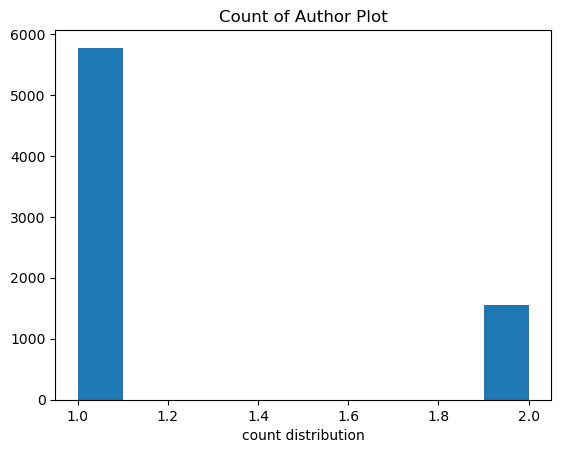

In [483]:
author_counts = all_author['full_name'].value_counts()
author_counts

plt.hist(author_counts, range = (1, 2))
plt.xlabel('count distribution')
plt.title('Count of Author Plot')
plt.show()

In [484]:
less_freq_author= pd.DataFrame(author_counts).query('full_name <= 2').index.to_list()
print(f"There are {len(less_freq_author)} less-frequent authors.")

mid_freq_author= pd.DataFrame(author_counts).query('full_name > 2 & full_name < 10').index.to_list()
print(f"There are {len(mid_freq_author)} mid-frequent authors.")

high_freq_author= pd.DataFrame(author_counts).query('full_name >= 10').index.to_list()
print(f"There are {len(high_freq_author)} high-frequent authors.")


There are 7329 less-frequent authors.
There are 1703 mid-frequent authors.
There are 349 high-frequent authors.


In [485]:
#creating new binary column to see if article contains most common authors
metadata_df["less_freq_author"] = metadata_df["full_name"].apply(lambda x: any(item in x for item in less_freq_author) )
metadata_df["mid_freq_author"] = metadata_df["full_name"].apply(lambda x: any(item in x for item in mid_freq_author) )
metadata_df["high_freq_author"] = metadata_df["full_name"].apply(lambda x: any(item in x for item in high_freq_author) )

# Check distribution in two target classes
metadata_df.groupby('target')['less_freq_author'].sum()

target
0    301
1    377
Name: less_freq_author, dtype: int64

In [486]:
metadata_df.groupby('target')['mid_freq_author'].sum()

target
0    130
1    470
Name: mid_freq_author, dtype: int64

In [487]:
metadata_df.groupby('target')['high_freq_author'].sum()

target
0     19
1    485
Name: high_freq_author, dtype: int64

### Tidy - Common Jounal Variable

In [488]:
all_journal = pd.read_csv('../data/raw/article_list/journals.csv', header=None, skiprows=2)

all_journal.head()


0
0  Frontiers in Forests and Global Change
1              Canadian Journal of Botany
2  Geological Society of America Bulletin
3                                 Ecology
4                                 Ecology

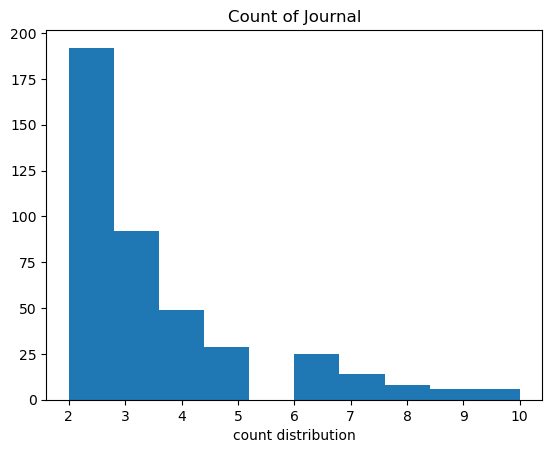

In [489]:
journal_counts = all_journal[0].value_counts()
journal_counts_df = pd.DataFrame(journal_counts).rename(columns= {0: "journal"})

plt.hist(journal_counts_df, range = (2, 10))
plt.xlabel('count distribution')
plt.title('Count of Journal')
plt.show()

> Investigate the break points for journal counts

In [490]:
less_freq_journal= journal_counts_df.query('journal == 1').index.to_list()
print(f"There are {len(less_freq_journal)} less-frequent journals.")

mid_freq_journal= journal_counts_df.query('journal > 1 & journal <= 5').index.to_list()
print(f"There are {len(mid_freq_author)} mid-frequent journals.")

high_freq_journal= journal_counts_df.query('journal > 5').index.to_list()
print(f"There are {len(high_freq_journal)} high-frequent journals.")

There are 1171 less-frequent journals.
There are 1703 mid-frequent journals.
There are 124 high-frequent journals.


In [491]:
def journal_encoder(journal_name):
    if journal_name in less_freq_journal:
        return 1
    elif journal_name in mid_freq_journal:
        return 2
    elif journal_name in high_freq_journal:
        return 3
    else:
        return 0

In [549]:
# creating new binary column to see if article contains most common journal
metadata_df["common_journal"] = metadata_df["container-title"].apply(journal_encoder)

# Check distribution in two target classes
metadata_df["common_journal"].value_counts

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/2823430953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df["common_journal"] = metadata_df["container-title"].apply(journal_encoder)


<bound method IndexOpsMixin.value_counts of 0       2
1       3
2       1
3       3
4       3
       ..
3025    0
3026    0
3027    0
3028    0
3029    3
Name: common_journal, Length: 3015, dtype: int64>

### Feature Engineering - Descriptive Text

Due to the descriptive nature of subject, title, subtitle and abstract, we will create a new text column that concatenate all these descriptive words into a single string for each observation.

In [550]:
# concatenate journal
metadata_df['container-title'] = metadata_df['container-title'].apply(lambda x: ''.join(x))

# concatenate title & subtitle
metadata_df['title_clean'] = metadata_df['title'].apply(lambda x: ''.join(x))
metadata_df['subtitle_clean'] = metadata_df['subtitle'].apply(lambda x: ''.join(x))

# # concatenate abstract (first replace NaN values)
metadata_df['abstract_clean'] = metadata_df['abstract'].fillna(value='')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].apply(lambda x: ''.join(x))

# # concatenate subject (first replace missing values)
metadata_df['subject_clean'] = metadata_df['subject'].fillna(value='')
metadata_df['subject_clean'] = metadata_df['subject_clean'].apply(lambda x: ' '.join(x))

metadata_df.head(1)

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/2295881361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['container-title'] = metadata_df['container-title'].apply(lambda x: ''.join(x))
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/2295881361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['title_clean'] = metadata_df['title'].apply(lambda x: ''.join(x))
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/2295881361.py:6: Sett

DOI                                          URL  \
0  10.2478/s11756-007-0072-x  http://dx.doi.org/10.2478/s11756-007-0072-x   

  abstract  \
0      NaN   

                                                                                                                                                                                                    author  \
0  [{'given': 'Miroslava', 'family': 'Pražáková', 'sequence': 'first', 'affiliation': []}, {'given': 'Josef', 'family': 'Veselý', 'sequence': 'additional', 'affiliation': []}, {'given': 'Jan', 'famil...   

  container-title is-referenced-by-count language  \
0        Biologia                     13       en   

                      published                                publisher  \
0  {'date-parts': [[2006, 12]]}  Springer Science and Business Media LLC   

                                                                                                                                              subject  \
0  [Cell Biology, Plant Science, Genetics, Molecular Biology, Animal Science and Zoology, Biochemistry, Ecology, Evolution, Behavior and Systematics]   

   ... mid_freq_author high_freq_author  common_journal  \
0  ...            True            False               2   

                                                                                                                          title_clean  \
0  The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest   

  subtitle_clean  abstract_clean  \
0                                  

                                                                                                                                subject_clean  \
0  Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics   

                                                                                                                                                                                        text_with_abstract  \
0  Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics The long-term succession of cladoceran fauna and palaeocl...   

                                                                                                                                                                                          text_wo_abstract  \
0  Cell Biology Plant Science Genetics Molecular Biology Animal Science and Zoology Biochemistry Ecology, Evolution, Behavior and Systematics The long-term succession of cladoceran fauna and palaeocl...   

  detectlang  
0         en  

[1 rows x 26 columns]

##### Clean up json tags in abstract raw text using RegEx

In [551]:
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(list|inline-graphic|related-article).*>', repl = ' ')

# All Cleaned
metadata_df['abstract_clean'][metadata_df['abstract_clean'].str.contains('jats')]

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/492611570.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/492611570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['abstract_clean'] = metadata_df['abstract_clean'].str.replace(pat = '<(jats|/jats):(p|sec|title|italic|sup|sub)>', repl = ' ')
/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/492611570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.

Series([], Name: abstract_clean, dtype: object)

> In this step, we did not join abstract with the text to investigate model performance when abstract is not used as a feature

In [629]:
metadata_df['has_abstract'] = metadata_df["abstract"].isnull().astype(int)
metadata_df["has_abstract"].value_counts()


1    2286
0     729
Name: has_abstract, dtype: int64

In [ ]:

# create description text column
metadata_df['text_with_abstract'] = metadata_df['subject_clean'] + ' ' + metadata_df['title_clean'] + ' ' + metadata_df['subtitle_clean'] + ' ' + metadata_df['abstract_clean']
metadata_df['text_wo_abstract'] = metadata_df['subject_clean'] + ' ' + metadata_df['title_clean'] + ' ' + metadata_df['subtitle_clean']

In [553]:

metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3029
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DOI                     3015 non-null   object
 1   URL                     3015 non-null   object
 2   abstract                729 non-null    object
 3   author                  2561 non-null   object
 4   container-title         3015 non-null   object
 5   is-referenced-by-count  3015 non-null   object
 6   language                3015 non-null   object
 7   published               3015 non-null   object
 8   publisher               3011 non-null   object
 9   subject                 2945 non-null   object
 10  subtitle                3015 non-null   object
 11  title                   3015 non-null   object
 12  target                  3015 non-null   int64 
 13  published_year          3015 non-null   int64 
 14  full_name               3015 non-null   object
 15  less

### Tidy - Language

Most of the articles are English. Thus we will drop this column.

In [554]:
# Use language detector 
from langdetect import detect

In [555]:
metadata_df['detectlang'] = metadata_df['text_wo_abstract'].apply(lambda x: 'en' if'en' in detect(x) else "NA")

/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/4247551011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['detectlang'] = metadata_df['text_wo_abstract'].apply(lambda x: 'en' if'en' in detect(x) else "NA")


> The language detector is not really trust worthy.

In [556]:
metadata_df.query('detectlang == False & language == "en"').shape

(0, 26)

In [557]:
metadata_df.query('language != "en"').head()

Empty DataFrame
Columns: [DOI, URL, abstract, author, container-title, is-referenced-by-count, language, published, publisher, subject, subtitle, title, target, published_year, full_name, less_freq_author, mid_freq_author, high_freq_author, common_journal, title_clean, subtitle_clean, abstract_clean, subject_clean, text_with_abstract, text_wo_abstract, detectlang]
Index: []

[0 rows x 26 columns]

In [558]:
metadata_df['language'] = metadata_df['language'].fillna(metadata_df['detectlang']).replace(True, 'en')
metadata_df['language'].info()

<class 'pandas.core.series.Series'>
Int64Index: 3015 entries, 0 to 3029
Series name: language
Non-Null Count  Dtype 
--------------  ----- 
3015 non-null   object
dtypes: object(1)
memory usage: 47.1+ KB


/var/folders/2l/nvvbpy0945b9p2hxcvqg0r640000gn/T/ipykernel_20079/1507112380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['language'] = metadata_df['language'].fillna(metadata_df['detectlang']).replace(True, 'en')


In [559]:
# With Imputed Language, Filter out non-english articles
metadata_df = metadata_df.query('language == "en"')
metadata_df.shape

(3015, 26)

### Tidy - Publisher

We noticed that the major publishers will publish both relevant and non-relevant articles. This variable might not be too informative for the classification task.

We decided to:
- Drop this feature for logistic regression model since it will introduce data sparsity.
- May keep this feature for more sophisticated ML models and try if it could improve model performance.

In [560]:
metadata_df.groupby('target')['publisher'].value_counts()

metadata_df.query("publisher == 'Elsevier BV'")['target'].value_counts()

0    484
1    181
Name: target, dtype: int64

### Save Cleaned Data

In [561]:
# saving processed dataframe
directory = '../data/processed'
if not os.path.exists(directory):
    os.makedirs(directory)

metadata_df.to_csv("../data/processed/metadata_processed.csv")

## 3. Create Training and Testing Data for Baseline Model

Note: Also dropped container-title (journal name) to evaluate if the binary common_journal help reduce dimension.

In [562]:
metadata_df.columns

Index(['DOI', 'URL', 'abstract', 'author', 'container-title',
       'is-referenced-by-count', 'language', 'published', 'publisher',
       'subject', 'subtitle', 'title', 'target', 'published_year', 'full_name',
       'less_freq_author', 'mid_freq_author', 'high_freq_author',
       'common_journal', 'title_clean', 'subtitle_clean', 'abstract_clean',
       'subject_clean', 'text_with_abstract', 'text_wo_abstract',
       'detectlang'],
      dtype='object')

In [563]:
training_keepcol = [
       'is-referenced-by-count', 'language', 'target', 'published_year',
       'less_freq_author', 'mid_freq_author', 'high_freq_author',
       'common_journal', 'text_with_abstract', 'text_wo_abstract']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3029
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  3015 non-null   object
 1   language                3015 non-null   object
 2   target                  3015 non-null   int64 
 3   published_year          3015 non-null   int64 
 4   less_freq_author        3015 non-null   bool  
 5   mid_freq_author         3015 non-null   bool  
 6   high_freq_author        3015 non-null   bool  
 7   common_journal          3015 non-null   int64 
 8   text_with_abstract      3015 non-null   object
 9   text_wo_abstract        3015 non-null   object
dtypes: bool(3), int64(3), object(4)
memory usage: 197.3+ KB


In [564]:
# metadata_df_cleaned.head(2)

#### Imports for Baseline Model

In [565]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

### Train-Test Split

0.2: small sample

In [566]:
train_df, test_df = train_test_split(metadata_df_cleaned, test_size=0.2, random_state=123)
train_df.head()

is-referenced-by-count language  target  published_year  \
752                      35       en       1            2017   
2104                     18       en       0            2015   
754                      12       en       1            1995   
2905                      0       en       0            2023   
1765                      0       en       0            2007   

      less_freq_author  mid_freq_author  high_freq_author  common_journal  \
752               True            False              True               3   
2104             False            False             False               0   
754               True            False             False               0   
2905              True            False             False               0   
1765             False            False             False               0   

                                                                                                                                                                                           text_with_abstract  \
752   Geology Archeology Archeology Ecology, Evolution, Behavior and Systematics Global and Planetary Change Patterns of hydroclimatic change in the Rocky Mountains and surrounding regions since the las...   
2104  Law Management, Monitoring, Policy and Law Economics and Econometrics Sociology and Political Science Application of multi-criteria decision making/operations research techniques for sustainable m...   
754                                                                   Geological contexts of the early and middle Holocene archaeological record in North Dakota and adjoining areas of the Northern Plains     
2905  Plant Science Genome-wide characterization and expression analysis of MYB transcription factors in Chrysanthemum nankingense  Chrysanthemum is a popular ornamental plant worldwide. MYB (v-myb avia...   
1765                                                                                                             Pharmacology (medical) Infectious Diseases The HIV Pandemic: Local and Global Implications     

                                                                                                                                                                                             text_wo_abstract  
752   Geology Archeology Archeology Ecology, Evolution, Behavior and Systematics Global and Planetary Change Patterns of hydroclimatic change in the Rocky Mountains and surrounding regions since the las...  
2104  Law Management, Monitoring, Policy and Law Economics and Econometrics Sociology and Political Science Application of multi-criteria decision making/operations research techniques for sustainable m...  
754                                                                    Geological contexts of the early and middle Holocene archaeological record in North Dakota and adjoining areas of the Northern Plains   
2905                                                                            Plant Science Genome-wide characterization and expression analysis of MYB transcription factors in Chrysanthemum nankingense   
1765                                                                                                              Pharmacology (medical) Infectious Diseases The HIV Pandemic: Local and Global Implications

## 4. More EDA for Train Split

In [567]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 752 to 1353
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  2412 non-null   object
 1   language                2412 non-null   object
 2   target                  2412 non-null   int64 
 3   published_year          2412 non-null   int64 
 4   less_freq_author        2412 non-null   bool  
 5   mid_freq_author         2412 non-null   bool  
 6   high_freq_author        2412 non-null   bool  
 7   common_journal          2412 non-null   int64 
 8   text_with_abstract      2412 non-null   object
 9   text_wo_abstract        2412 non-null   object
dtypes: bool(3), int64(3), object(4)
memory usage: 157.8+ KB


In [568]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [569]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)

print("Without Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_wo_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_wo_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_wo_abstract.str.len().mean()
avg_neg_len = neg_df.text_wo_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)


With Abstract
639.0384
474.9776161163962
Without Abstract
168.3024
141.0934527140459


In [570]:
sorted_pos_df.head()

is-referenced-by-count language  target  published_year  less_freq_author  \
369                      2       en       1            1975              True   
128                    108       en       1            2002             False   
571                     95       en       1            1999             False   
159                     50       en       1            2002             False   
295                     25       en       1            1997              True   

     mid_freq_author  high_freq_author  common_journal  \
369            False             False               0   
128            False              True               3   
571            False              True               3   
159            False              True               3   
295            False              True               3   

                             text_with_abstract  \
369       Descriptions of WHOI sediment cores     
128  Earth-Surface Processes Aquatic Science      
571  Earth-Surface Processes Aquatic Science      
159  Earth-Surface Processes Aquatic Science      
295  Earth-Surface Processes Aquatic Science      

                              text_wo_abstract  
369       Descriptions of WHOI sediment cores   
128  Earth-Surface Processes Aquatic Science    
571  Earth-Surface Processes Aquatic Science    
159  Earth-Surface Processes Aquatic Science    
295  Earth-Surface Processes Aquatic Science

In [571]:
sorted_neg_df.head()

is-referenced-by-count language  target  published_year  \
1957                      0       en       0            2015   
1091                      0       en       0            2015   
1172                      2       en       0            2015   
2305                      0       en       0            2015   
1567                      0       en       0            2015   

      less_freq_author  mid_freq_author  high_freq_author  common_journal  \
1957             False            False             False               0   
1091             False            False             False               0   
1172             False            False             False               0   
2305             False            False             False               0   
1567             False            False             False               0   

          text_with_abstract       text_wo_abstract  
1957                 Cover                   Cover   
1091             Editorial               Editorial   
1172           Tit for Tat             Tit for Tat   
2305         Cover Picture           Cover Picture   
1567   List of Periodicals     List of Periodicals

#### Word Cloud

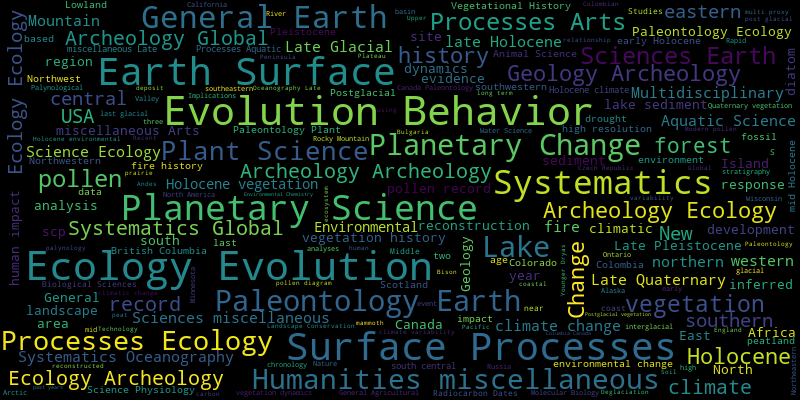

In [572]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_wo_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_wo_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

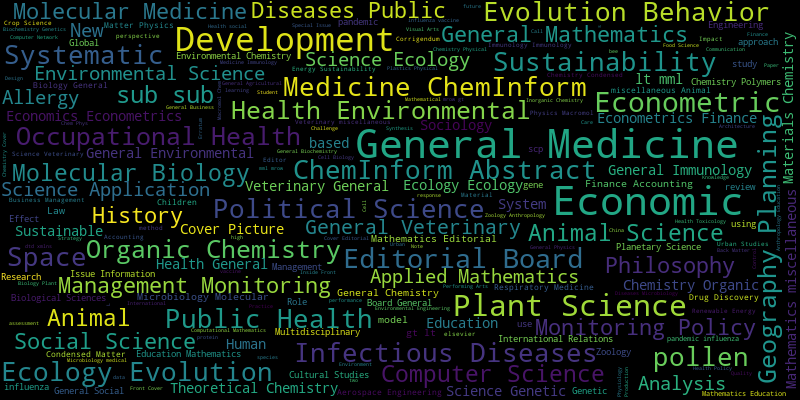

In [573]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [574]:
train_df["target"].value_counts(normalize=True)

0    0.740879
1    0.259121
Name: target, dtype: float64

## 5. Baseline Modelling

In [575]:
train_df.columns

Index(['is-referenced-by-count', 'language', 'target', 'published_year',
       'less_freq_author', 'mid_freq_author', 'high_freq_author',
       'common_journal', 'text_with_abstract', 'text_wo_abstract'],
      dtype='object')

##### Split X and y

- Using Text Without Abstract
- Use ordinal journal & 3-category author

In [615]:
# feature = ['is-referenced-by-count', 'language', 'published_year',
#        'less_freq_author', 'mid_freq_author', 'high_freq_author',
#        'common_journal', 'text_wo_abstract']

# No author
# feature = ['is-referenced-by-count', 'language', 'published_year',
#        'common_journal', 'text_wo_abstract']

# With abstract, With author
feature = ['is-referenced-by-count', 'language', 'published_year',
       'less_freq_author', 'mid_freq_author', 'high_freq_author',
       'common_journal', 'text_with_abstract']

# Drop Year, With Abstract, With Author
feature = ['is-referenced-by-count', 'language', 
       'less_freq_author', 'mid_freq_author', 'high_freq_author',
       'common_journal', 'text_with_abstract']

X_train, y_train = train_df[feature], train_df["target"]
X_test, y_test = test_df[feature], test_df["target"]

##### Define Pre-Processing Pipeline

In [616]:
from sklearn.compose import make_column_transformer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Dividing the feature types
text_features = "text_with_abstract"
binary_feature = ['less_freq_author', 'mid_freq_author', 'high_freq_author']
ordinal_feature = ['common_journal']
# numeric_features = ["is-referenced-by-count", "published_year"]
numeric_features = ["is-referenced-by-count"]


# Transformers
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)
# categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype = int)
numeric_transformer = StandardScaler()
text_transformer = CountVectorizer(stop_words="english", max_features= 100)

author_levels = [0,1,2,3]
ordinal_transformer = OrdinalEncoder(categories=[author_levels], dtype=int)

# Create the column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_feature),
    (ordinal_transformer, ordinal_feature),
    (text_transformer, text_features)
)

preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['less_freq_author', 'mid_freq_author',
                                  'high_freq_author']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[[0, 1, 2, 3]],
                                                dtype=<class 'int'>),
                                 ['common_journal']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'text_with_abstract')])

##### Check Transformed Data

In [617]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

<2412x105 sparse matrix of type '<class 'numpy.float64'>'
	with 21134 stored elements in Compressed Sparse Row format>

In [618]:
col_names = (numeric_features + preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist() + preprocessor.named_transformers_["ordinalencoder"].get_feature_names_out().tolist() + preprocessor.named_transformers_["countvectorizer"].get_feature_names_out().tolist())

# no author
# col_names = (numeric_features + preprocessor.named_transformers_["ordinalencoder"].get_feature_names_out().tolist() + preprocessor.named_transformers_["countvectorizer"].get_feature_names_out().tolist())


len(col_names)

transformed_X_train_df = pd.DataFrame.sparse.from_spmatrix(transformed_X_train, columns=col_names)
transformed_X_train_df.head(3)

is-referenced-by-count  less_freq_author_True  mid_freq_author_True  \
0                0.426147                    1.0                   0.0   
1                0.022167                    0.0                   0.0   
2               -0.120413                    1.0                   0.0   

   high_freq_author_True  common_journal  000   10  abstract  analysis  \
0                    1.0             3.0  0.0  0.0       0.0       0.0   
1                    0.0             0.0  0.0  0.0       0.0       0.0   
2                    0.0             0.0  0.0  0.0       0.0       0.0   

   animal  ...  systematics  time  use  used  using  vegetation  water  xa0  \
0     0.0  ...          1.0   0.0  0.0   0.0    0.0         0.0    0.0  0.0   
1     0.0  ...          0.0   0.0  0.0   0.0    0.0         0.0    0.0  0.0   
2     0.0  ...          0.0   0.0  0.0   0.0    0.0         0.0    0.0  0.0   

   years   yr  
0    0.0  0.0  
1    0.0  0.0  
2    0.0  0.0  

[3 rows x 105 columns]

#### Logistic Regression

In [619]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

mean    std
fit_time         0.127  0.013
score_time       0.027  0.001
test_accuracy    0.980  0.009
train_accuracy   0.993  0.002
test_precision   0.966  0.026
train_precision  0.995  0.002
test_recall      0.957  0.017
train_recall     0.979  0.005
test_f1          0.961  0.018
train_f1         0.987  0.003

#### LogReg - Preliminary investigation on feature importance for Logistic Regression

In [620]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [621]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['less_freq_author',
                                                   'mid_freq_author',
                                                   'high_freq_author']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                              3]],
                                                                 dtype=<class 'int'>),
                                                  ['common_journal']),
                                                 ('countvectorizer',
                                                  CountVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'text_with_abstract')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [622]:
data = {
    "coefficient": logreg_model.named_steps["logisticregression"].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps["logisticregression"].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

coefficient  magnitude
high_freq_author_True      3.075839   3.075839
lake                       2.150037   2.150037
mid_freq_author_True       1.976943   1.976943
common_journal             1.811878   1.811878
late                       1.653343   1.653343
forest                     1.565876   1.565876
holocene                   1.424623   1.424623
less_freq_author_True      1.312508   1.312508
history                    1.301547   1.301547
vegetation                 1.039100   1.039100
paleontology               0.935683   0.935683
record                     0.891547   0.891547
glacial                    0.856278   0.856278
environmental              0.802587   0.802587
present                    0.735093   0.735093
10                         0.663175   0.663175
archeology                 0.555770   0.555770
evolution                  0.500722   0.500722
bp                         0.485347   0.485347
climate                    0.479155   0.479155
analysis                   0.406487   0.406487
high                       0.403354   0.403354
long                       0.363189   0.363189
sciences                   0.342343   0.342343
000                        0.270314   0.270314
early                      0.228870   0.228870
change                     0.228034   0.228034
biology                    0.224985   0.224985
surface                    0.208506   0.208506
is-referenced-by-count     0.189409   0.189409

In [623]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

coefficient  magnitude
sustainability    -1.297802   1.297802
animal            -1.223229   1.223229
influenza         -1.196352   1.196352
mathematics       -1.089114   1.089114
higher            -1.079208   1.079208
gene              -1.069213   1.069213
development       -1.008171   1.008171
important         -0.949689   0.949689
different         -0.891212   0.891212
economics         -0.863811   0.863811
computer          -0.863417   0.863417
health            -0.843043   0.843043
using             -0.830945   0.830945
specific          -0.806023   0.806023
editorial         -0.770535   0.770535
econometrics      -0.764294   0.764294
use               -0.754315   0.754315
results           -0.748092   0.748092
male              -0.728466   0.728466
chemistry         -0.688868   0.688868
study             -0.669893   0.669893
education         -0.663681   0.663681
diseases          -0.632666   0.632666
food              -0.545204   0.545204
miscellaneous     -0.530243   0.530243
based             -0.525870   0.525870
finance           -0.520696   0.520696
immunology        -0.513996   0.513996
expression        -0.476399   0.476399
sup               -0.471562   0.471562

### Build and Compare Multiple Models

In [624]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)


In [625]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier

results_dict = {}
models = {
	"dummy": DummyClassifier(random_state = 123),
    "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(random_state=123),
    'NaiveBayes': BernoulliNB(alpha=1)
}

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df



/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

fit_time         score_time      test_accuracy  \
dummy          0.106 (+/- 0.004)  0.028 (+/- 0.001)  0.741 (+/- 0.000)   
decision tree  0.113 (+/- 0.005)  0.028 (+/- 0.002)  0.965 (+/- 0.012)   
kNN            0.150 (+/- 0.018)  0.084 (+/- 0.023)  0.965 (+/- 0.009)   
RBF SVM        0.182 (+/- 0.016)  0.046 (+/- 0.001)  0.966 (+/- 0.008)   
RF             0.340 (+/- 0.022)  0.047 (+/- 0.016)  0.984 (+/- 0.006)   
LGBM           0.232 (+/- 0.023)  0.039 (+/- 0.003)  0.986 (+/- 0.005)   
NaiveBayes     0.119 (+/- 0.018)  0.031 (+/- 0.005)  0.965 (+/- 0.013)   

                  train_accuracy     test_precision    train_precision  \
dummy          0.741 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
decision tree  1.000 (+/- 0.000)  0.932 (+/- 0.033)  1.000 (+/- 0.000)   
kNN            0.975 (+/- 0.002)  0.962 (+/- 0.019)  0.974 (+/- 0.004)   
RBF SVM        0.990 (+/- 0.001)  0.979 (+/- 0.018)  0.991 (+/- 0.003)   
RF             1.000 (+/- 0.000)  0.984 (+/- 0.013)  0.999 (+/- 0.001)   
LGBM           1.000 (+/- 0.000)  0.976 (+/- 0.016)  1.000 (+/- 0.000)   
NaiveBayes     0.969 (+/- 0.001)  0.940 (+/- 0.019)  0.950 (+/- 0.005)   

                     test_recall       train_recall            test_f1  \
dummy          0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
decision tree  0.934 (+/- 0.015)  0.999 (+/- 0.001)  0.933 (+/- 0.022)   
kNN            0.901 (+/- 0.018)  0.929 (+/- 0.006)  0.931 (+/- 0.017)   
RBF SVM        0.890 (+/- 0.021)  0.971 (+/- 0.002)  0.932 (+/- 0.017)   
RF             0.955 (+/- 0.022)  1.000 (+/- 0.001)  0.969 (+/- 0.013)   
LGBM           0.970 (+/- 0.015)  0.999 (+/- 0.001)  0.973 (+/- 0.010)   
NaiveBayes     0.923 (+/- 0.034)  0.928 (+/- 0.003)  0.931 (+/- 0.026)   

                        train_f1  
dummy          0.000 (+/- 0.000)  
decision tree  0.999 (+/- 0.001)  
kNN            0.951 (+/- 0.003)  
RBF SVM        0.981 (+/- 0.001)  
RF             0.999 (+/- 0.001)  
LGBM           0.999 (+/- 0.001)  
NaiveBayes     0.939 (+/- 0.003)

## Intermediate Results Summary

- Exclude abstract, use binary author, keep OHE journal:
![result1](../assets/author_binary.png)

- Exclude abstract, use binary author and binary journal:
![result2](../assets/author_journal_binary.png)



- Exclude abstract, use 3-category author, ordinal journal, imputed language

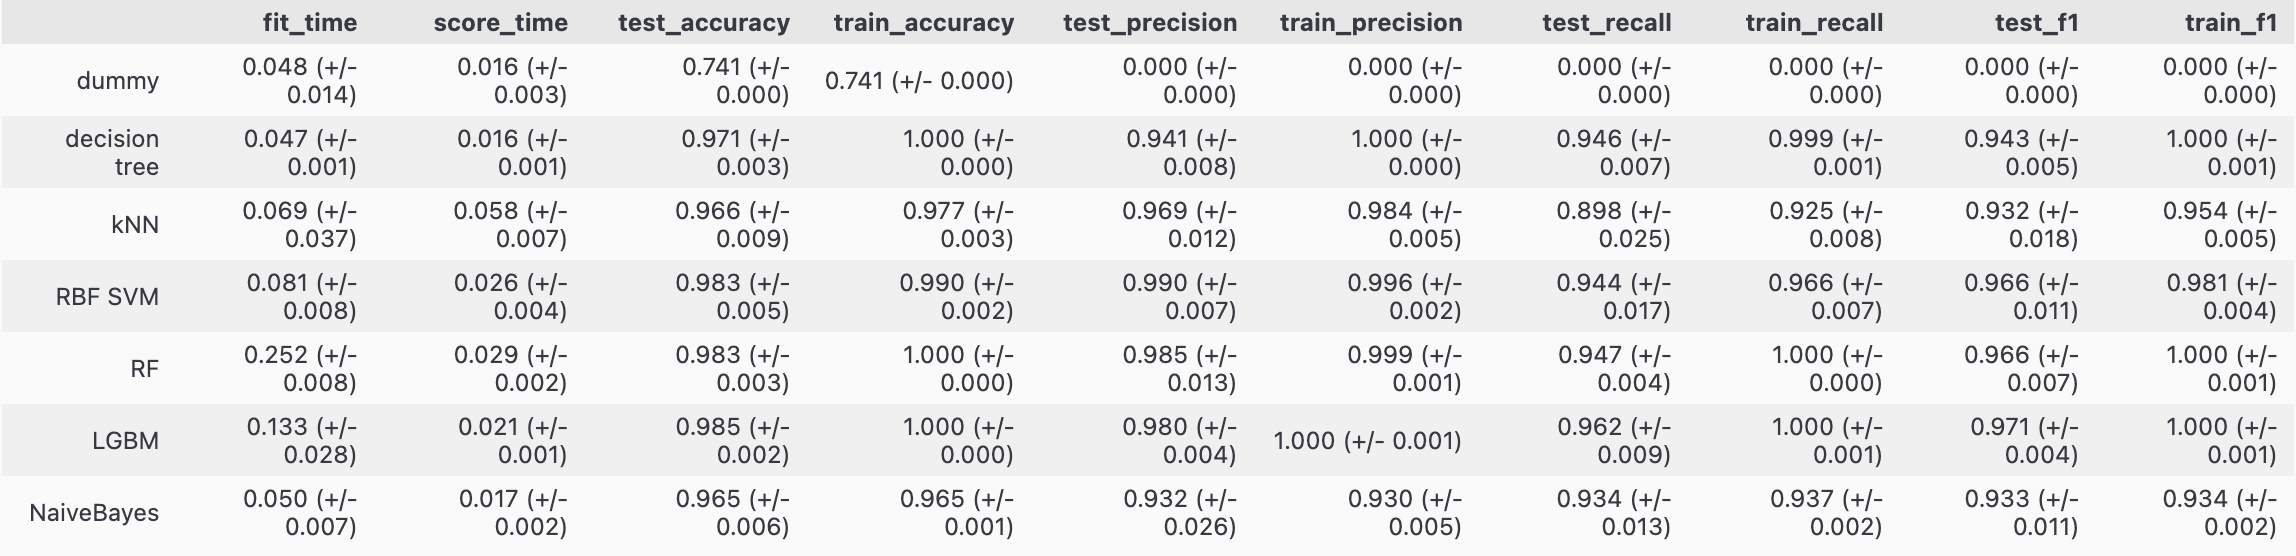

- Exclude abstract, Exclude 3-category author; Use ordinal journal, imputed language

(conclusion: Author seems to be a informative variable)

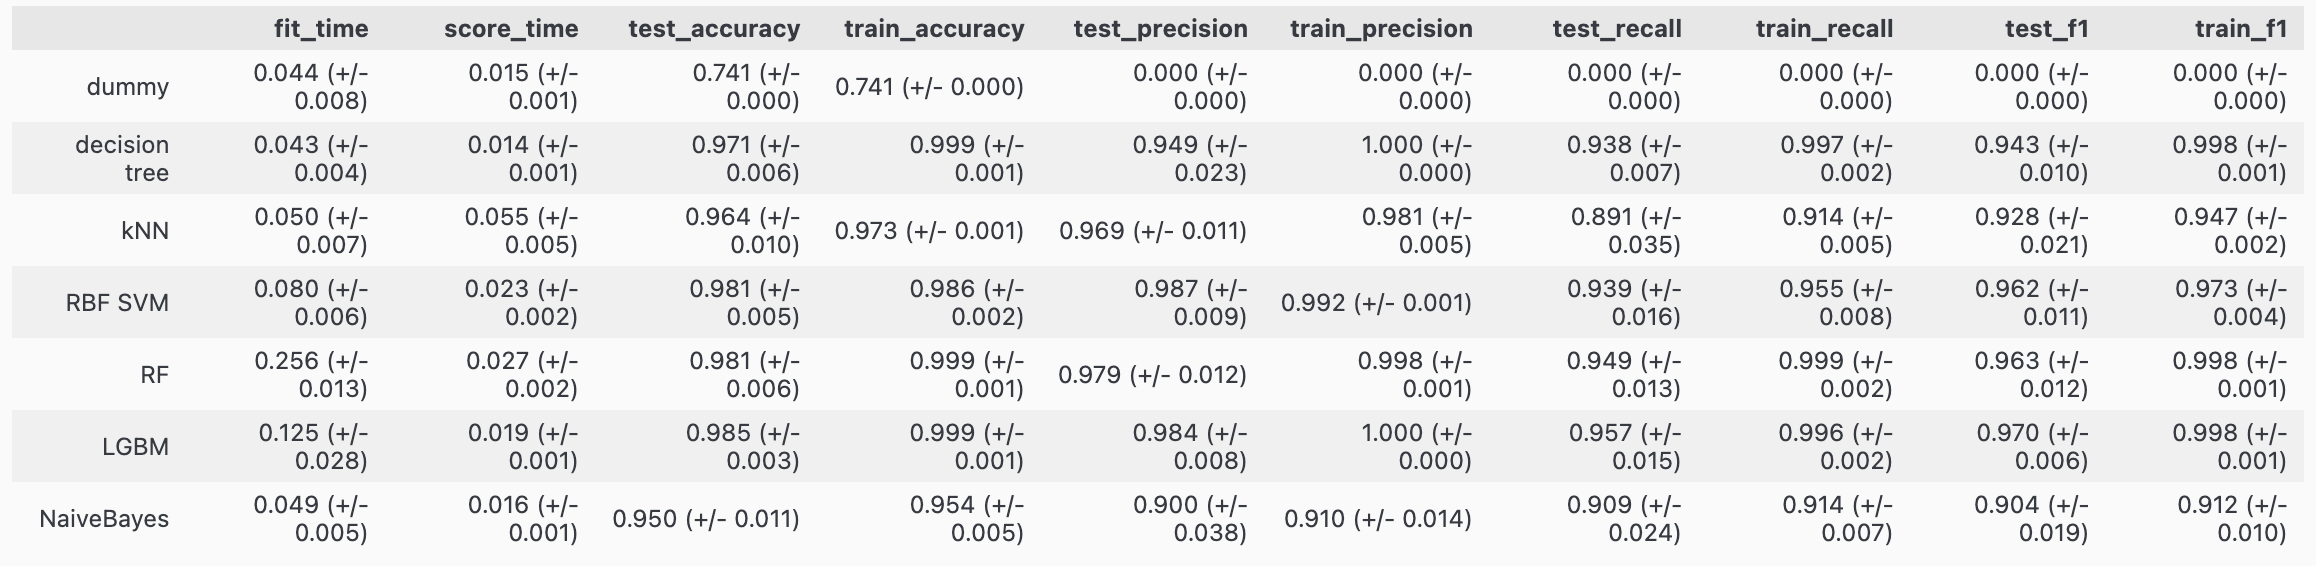

- Include Abstract, use 3-category author, ordinal journal, imputed language
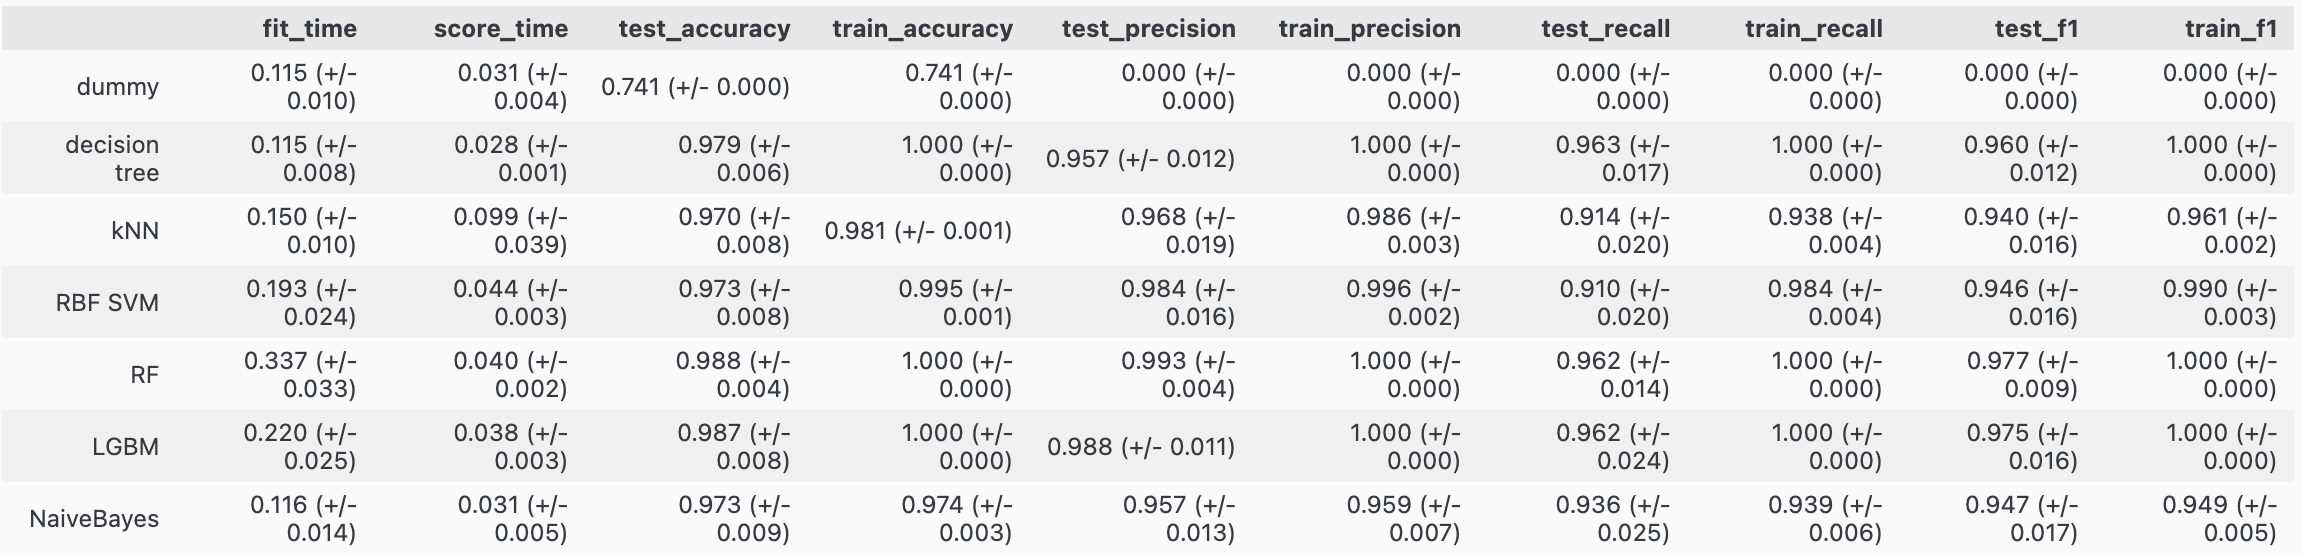

- Drop Year, Include Abstract, use 3-category author, ordinal journal, imputed language

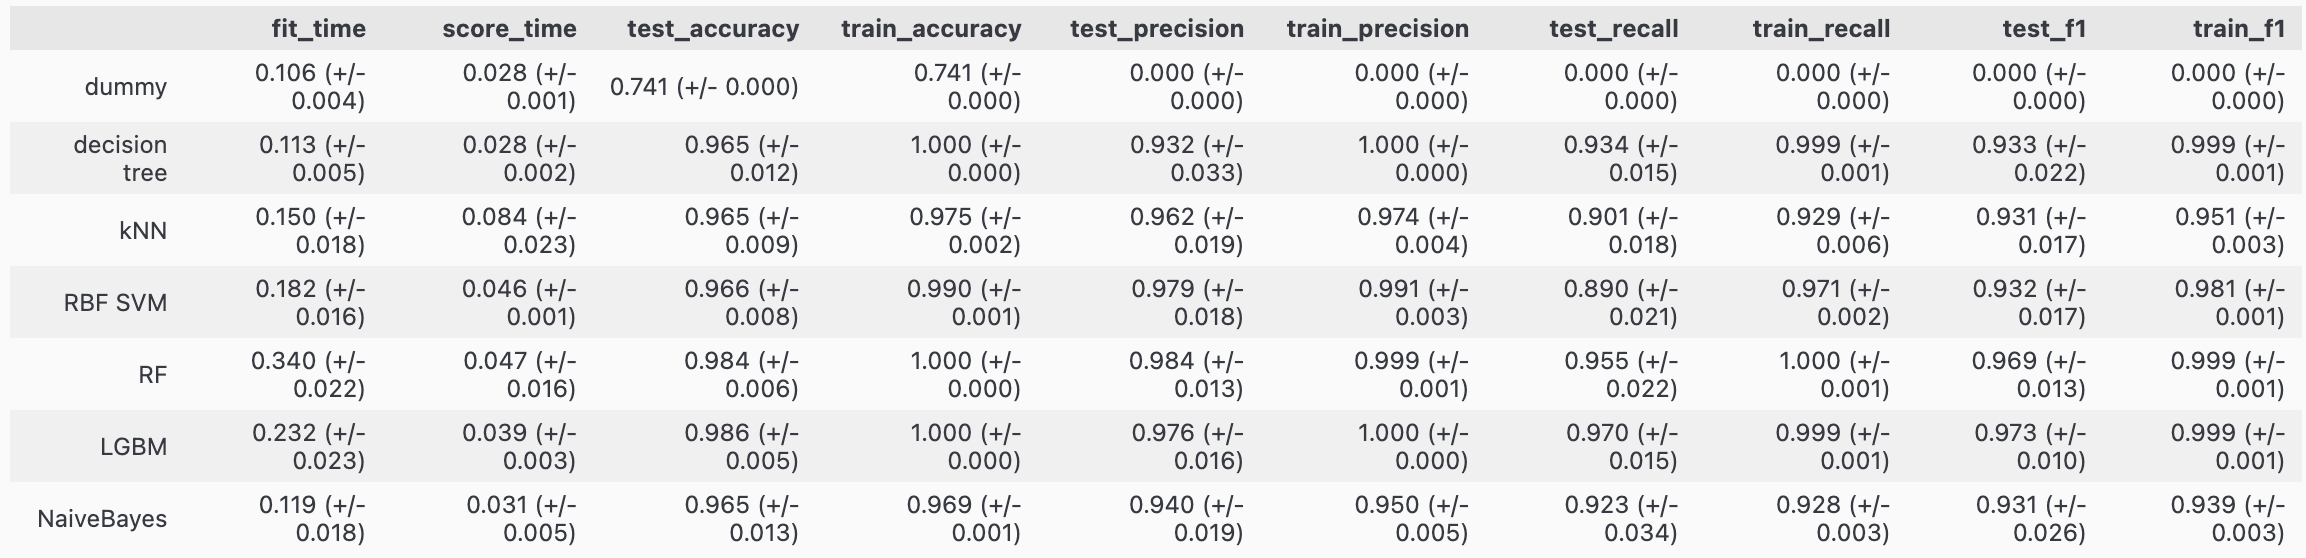

In [626]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, models['RF'].predict(X_test), target_names=[0, 1]
    )
)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### LogReg - Hyperparameter Tuning for Logistic Regression

In [208]:
# from scipy.stats import loguniform, randint

# # fit the model
# logreg_model.fit(X_train, y_train)

# # get the length of the vocabulary
# vocab_len = len(  
#     logreg_model.named_steps["columntransformer"]
#     .named_transformers_["countvectorizer"]
#     .get_feature_names_out()
# )
# # create a distribution of the parameters
# param_dist = {  
#     # "columntransformer__countvectorizer__max_features": np.arange(5000, vocab_len, 200),
#     "logisticregression__C": loguniform(1e-3, 1e3),
#     "logisticregression__class_weight": ["balanced", None],
# }

# # Perform a randomized search 
# random_search = RandomizedSearchCV(  
#     logreg_model,
#     param_distributions=param_dist,
#     n_iter=10,
#     verbose=1,
#     n_jobs=-1,
#     scoring='recall',
#     random_state=123,
# )
# random_search.fit(X_train, y_train)